In [24]:
import random
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
import gt4py as gt
import gt4py.cartesian.gtscript as gtscript

In [25]:
from common import initialize_field, plot_field

In [26]:
NX = 128
NY = 128
NZ = 80
N_ITER = 50

# Accelerate with GT4Py

We've already learnt about GT4Py on class. Here we compare its performance with other high-level language and assess the impact of different parameters under the new package version GT4Py 1.0.1. It needs to be marked here that the numpy version is 1.21.6, and python 3.9.4.

## Pointwise Stencils

First we want to see how GT4Py performs at pointwise copying. In GT4Py style, the stencil needs to be specifically defined apart from the function, and then compiled. You can also do that in one function with a decorator `@gtscript.stencil(backend=...,**kwargs)`, but then it would be more complex to control the backend type, so here we compile a stencil every time needed.

In [86]:
def gt4py_pointwise_def(
    in_field: gtscript.Field[np.float64],
    out_field: gtscript.Field[np.float64],
):

    with computation(PARALLEL), interval(...):
        out_field = in_field

def gt4py_pointwise(in_field, out_field):
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    domain = (
        in_field.shape[0],
        in_field.shape[1],
        in_field.shape[2]
    )
    # Iteration
    for n in range(N_ITER):
        
        gt4py_pointwise_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
            
    return out_field

In [87]:
backend = "numpy"
gt4py_pointwise_stencil = gtscript.stencil(backend=backend, definition=gt4py_pointwise_def)

Then we perform pointwise codes and record its time:

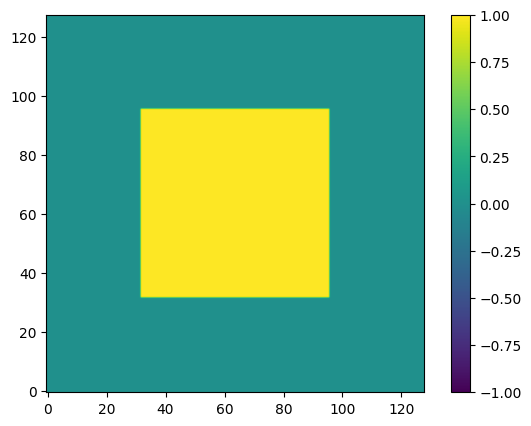

In [88]:
in_field = initialize_field(NX, NY, NZ, mode="square", dim_order="XYZ")
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.empty(in_field.shape, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_pointwise(in_field, out_field)
plot_field(out_field, dim_order="XYZ")

In [89]:
%%timeit in_field = initialize_field(NX, NY, NZ, mode="square", dim_order="XYZ"); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.empty(in_field.shape, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_pointwise(in_field, out_field)

3.02 ms ± 50.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Compared with vectorized numpy pointwise copy that uses about 33.3 ms, GT4Py is about 670 times faster. That is really impressive.

In the case above we define origin (starting index) and domain (computation region without halos) manually, like what we've learnt in class. Let's see if the performance changes with the default setting, which is possible in this example as the default setting is just what we need. This greatly simplify the function and looks much more intuitive.

In [95]:
def gt4py_pointwise_default(in_field, out_field):

    for n in range(N_ITER):
        gt4py_pointwise_stencil(
            in_field=in_field,
            out_field=out_field
        )
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

Here the stencil function is the same as the previous one, so we don't need to compile again.

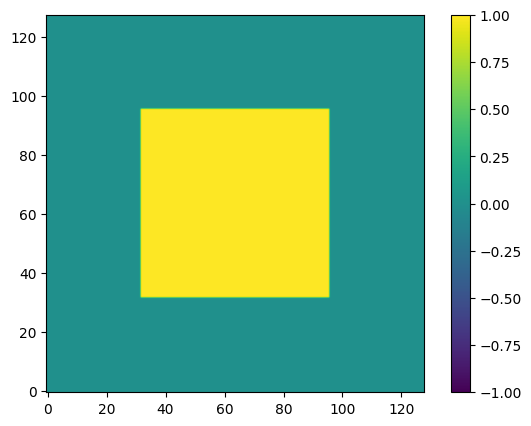

In [96]:
in_field = initialize_field(NX, NY, NZ, mode="square", dim_order="XYZ")
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.empty(in_field.shape, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_pointwise_default(in_field, out_field)
plot_field(out_field, dim_order="XYZ")

In [97]:
%%timeit in_field = initialize_field(NX, NY, NZ, mode="square", dim_order="XYZ"); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.empty(in_field.shape, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_pointwise_default(in_field, out_field)

3 ms ± 54.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


It seems that in this plain case the index and domain information can be omitted, and GT4Py will find it alone, which has almost no impact on the execution time, or it's even a bit faster.

| Function                           | Time    |
|:-----------------------------------|--------:|
| `list_pointwise()`                 |  8.4s   |
| `array_pointwise()`                |  15.3s  |
| `numpy_pointwise()`                |  60.8ms |
| `array_numba_pointwise()`          |  44.9ms |
| `array_numba_parallel_pointwise()` |  11.7ms |
| `numpy_numba_pointwise()`          |  55.9ms |
| `gt4py_pointwise()`                |  39.7ms |
| `gt4py_pointwise_default()`        |  39.7ms |

It's hard to implement Sin function using GT4Py, as functions like math.sin and np.sin cannot be imported inside a stencil, so there will not be any acceleration on sin calculation by GT4Py if you have to do this calculation outside the GT4Py stencil.

## 1D Stencils

Now we apply GT4Py to 1D stencil calculation. First is columnwise direction.

###  Same column: $a(i,j) = \frac{1}{2} \Big[b(i+1,j) - b(i,j)\Big]$

In [101]:
def gt4py_1D_same_col_def(
    in_field: gtscript.Field[np.float64],
    out_field: gtscript.Field[np.float64],
):
    
    with computation(PARALLEL), interval(...):
        # Apply 1D stencil in gt4py style
        out_field = 0.5 * (in_field[1, 0, 0] - in_field[0, 0, 0])

def gt4py_1D_same_col(in_field, out_field):
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    nx = in_field.shape[0] - 1
    domain = (
        nx,
        in_field.shape[1],
        in_field.shape[2]
    )
    # Iteration
    for n in range(N_ITER):
        # Update halo value
        in_field[nx, :, :] = in_field[0, :, :]
        
        gt4py_1D_same_col_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

In [102]:
backend = "numpy"
gt4py_1D_same_col_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_same_col_def)

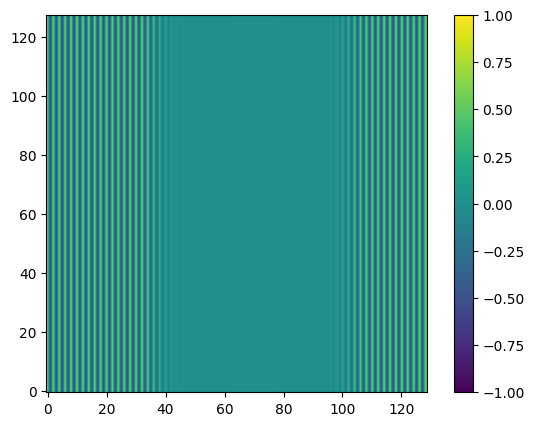

In [103]:
in_field = initialize_field(NX+1, NY, NZ, mode="vertical-bars", array_order="C", dim_order="XYZ")
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.empty(in_field.shape, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_col(in_field, out_field)
plot_field(out_field, dim_order="XYZ")

In [104]:
%%timeit in_field = initialize_field(NX+1, NY, NZ, mode="vertical-bars", array_order="C", dim_order="XYZ"); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.empty(in_field.shape, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_col(in_field, out_field)

116 ms ± 866 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The GT4Py 1D stencil is again about 1.8 times faster than numpy stencil (202 ms). Then we change the memory order of the array (here it's actually `gt.storage` class) to Fortran style to see if the duration change.

In [105]:
%%timeit in_field = initialize_field(NX+1, NY, NZ, mode="vertical-bars", array_order="F", dim_order="XYZ"); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.empty(in_field.shape, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_col(in_field, out_field)

116 ms ± 713 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The Fortran-style memory layout drags GT4Py a little bit. This is a bit surprising as it's the correct layout for a columnwise computation for GT4Py's `[i,j,k]` dimension sequence. A possible explanation is that GT4Py numpy backend is optimized specifically for C-style memory layout, as written in the document "*GT4Py takes your stencils written in GTScript and generates optimized C++ code, ...*"\
Another interesting thing to see is that the gap between two memory layout styles are relatively small (less than 10%). Other than here by GT4Py, only numpy row-like methods close this gap perfectly. This shows that `gt.storage` class still retains a memory order inherited from the numpy array, and that GT4Py may have special codes to cope with Fortran style arrays.

| Function                                        | Time   |
|:-----------------------------------------------:|-------:|
| `numpy_1D_same_col_order_C()`                   | 202ms  |
| `numpy_1D_same_col_order_F()`                   | 135ms  |
| `array_numba_parallel_1D_same_col_row_update()` | 58.2ms |
| `array_numba_parallel_1D_same_col_col_update()` | 11.8ms |
| `numpy_numba_1D_same_col_order_C()`             | 194ms  |
| `numpy_numba_1D_same_col_order_F()`             | 638ms  |
| `gt4py_1D_same_col_C()`                         | 153ms  |
| `gt4py_1D_same_col_F()`                         | 142ms  |

Now let's check its performance with rowwise setup:

###  Same row: $a(i,j) = \frac{1}{2} \Big[b(i,j+1) - b(i,j)\Big]$

In [106]:
def gt4py_1D_same_row_def(
    in_field: gtscript.Field[np.float64],
    out_field: gtscript.Field[np.float64],
):

    with computation(PARALLEL), interval(...):
        # Apply 1D stencil in gt4py style
        out_field = 0.5 * (in_field[0, 1, 0] - in_field[0, 0, 0])

def gt4py_1D_same_row(in_field, out_field):
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    ny = in_field.shape[1] - 1
    domain = (
        in_field.shape[0],
        ny,
        in_field.shape[2]
    )
    # Iteration
    for n in range(N_ITER):
        # Update halo value
        in_field[:, ny, :] = in_field[:, 0, :]
        
        gt4py_1D_same_row_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

In [107]:
backend = "numpy"
gt4py_1D_same_row_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_same_row_def)

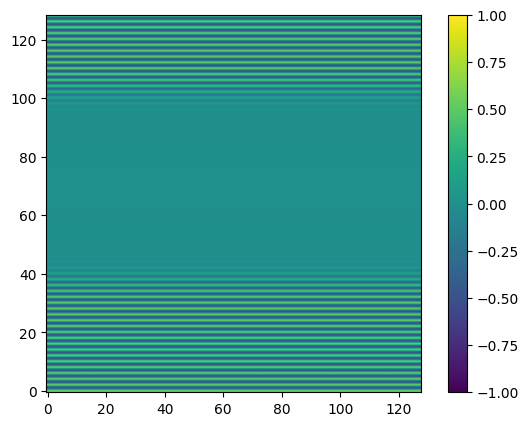

In [109]:
in_field = initialize_field(NX, NY+1, NZ, mode="horizontal-bars", array_order="C", dim_order="XYZ")
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.empty(in_field.shape, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_row(in_field, out_field)
plot_field(out_field, dim_order="XYZ")

In [111]:
%%timeit in_field = initialize_field(NX+1, NY, NZ, mode="horizontal-bars", array_order="C", dim_order="XYZ"); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.empty(in_field.shape, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_row(in_field, out_field)

111 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [112]:
%%timeit in_field = initialize_field(NX+1, NY, NZ, mode="horizontal-bars", array_order="F", dim_order="XYZ"); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.empty(in_field.shape, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_row(in_field, out_field)

111 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The Fortran-style memory layout is always a bit slower, consistent with our former guess that it's optimized for C-style layout.

## 2D stencils
Just like what we've done with Numba, we compare GT4Py performance on 2D stencils with numpy. This time we can directly import functions from the class. As the GT4Py version here is 1.0.1, minor changes have been made.

In [113]:
from stencil2d_gt4py import diffusion_defs, copy_defs

from stencil2d_gt4py import laplacian as laplacian_gt4py
from stencil2d_gt4py import update_halo as update_halo_gt4py
from stencil2d_gt4py import apply_diffusion as apply_diffusion_gt4py

In [114]:
from stencil2d import laplacian, update_halo, apply_diffusion

First we see how the GT4Py laplacian operation performs compared to vectorized numpy.

In [115]:
%%timeit in_field = initialize_field(NX, NY, NZ, num_halo=2, mode="square"); out_field = np.empty_like(in_field)
laplacian(in_field, out_field, num_halo=2)

6.5 ms ± 43.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [116]:
%%timeit in_field = initialize_field(NX, NY, NZ, num_halo=2, mode="square", dim_order="XYZ"); in_field = gt.storage.from_array(in_field, backend="numpy", aligned_index=(2, 2, 0)); out_field = gt.storage.empty(in_field.shape, backend="numpy", aligned_index=(2, 2, 0))
out_field = laplacian_gt4py(in_field)

843 ns ± 14.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


And it's much faster by over 8000 times. The stencil-specific optimization of GT4Py is very powerful.\
Next we inspect the halo update function. Here copy function specified for GT4Py stencils are required, so we compile it as well as the diffusion function from the definition function.

In [117]:
backend = "numpy"
dtype = np.float64
copy_stencil = gtscript.stencil(
    backend=backend,
    definition=copy_defs, 
    dtypes={"dtype": dtype}
)

diffusion_stencil = gtscript.stencil(
    backend=backend, 
    definition=diffusion_defs,
    dtypes={"dtype": dtype},
    externals={"laplacian": laplacian_gt4py}
)

True

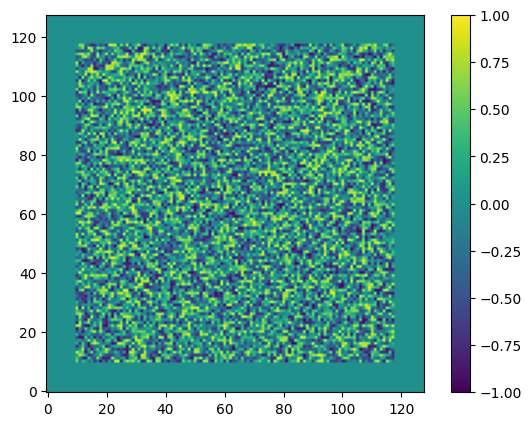

In [125]:
field = initialize_field(NX, NY, NZ, mode="random", num_halo=10, dim_order="XYZ")
field = gt.storage.from_array(field, backend="numpy", aligned_index=(10, 10, 0))
copy_field = gt.storage.from_array(field, backend="numpy", aligned_index=(10, 10, 0))
plot_field(field, dim_order="XYZ")
np.array_equal(field, copy_field)

False

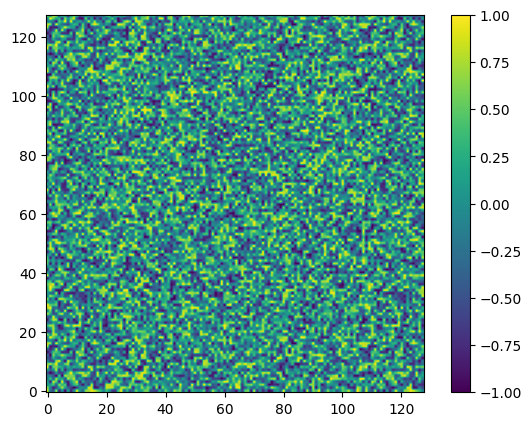

In [126]:
field = np.swapaxes(field, 0, 2)
update_halo(field, num_halo=10)
field = np.swapaxes(field, 0, 2)
plot_field(field, dim_order="XYZ")
np.array_equal(field, copy_field)

True

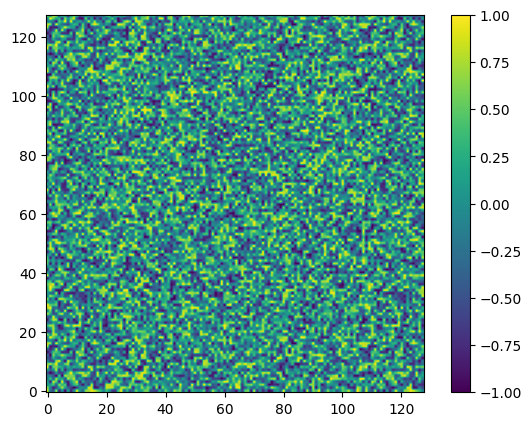

In [127]:
update_halo_gt4py(copy_stencil, copy_field, num_halo=10)
plot_field(copy_field,dim_order="XYZ")
np.array_equal(field, copy_field)

In [128]:
%%timeit field = initialize_field(NX, NY, NZ, mode="random"); copy_field = field.copy()
update_halo(field, num_halo=2)

630 µs ± 7.43 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [129]:
%%timeit field = initialize_field(NX, NY, NZ, mode="random", dim_order="XYZ"); field = gt.storage.from_array(field, backend="numpy", aligned_index=(0, 0, 0)); copy_field = gt.storage.from_array(field, backend="numpy", aligned_index=(0, 0, 0))
update_halo_gt4py(copy_stencil, field, num_halo=2)

332 µs ± 7.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Again GT4Py is faster than vectorized numpy for halo update. Other than reading in the whole array indices of both in_field and out_field like numpy does, GT4Py updates the halo only by reading the origin point index of the single stencil. This alleviates the memory-reading bottleneck and mostly explains its performance boost.

Now we test the 2D stencil function apply_diffusion and see difference in their performances.

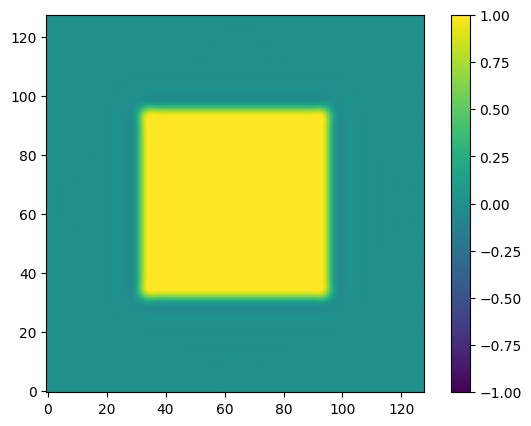

In [132]:
in_field = initialize_field(NX, NY, NZ, mode="square", num_halo=0)
out_field = np.empty_like(in_field)
in_field2 = initialize_field(NX, NY, NZ, dim_order="XYZ", mode="square", num_halo=0)
in_field2 = gt.storage.from_array(in_field2, backend="numpy", aligned_index=(2, 2, 0))
out_field2 = gt.storage.empty(in_field2.shape, backend="numpy", aligned_index=(2, 2, 0))

alpha = 1.0 / 32.0

apply_diffusion(in_field, out_field, num_halo=2, num_iter=N_ITER)
apply_diffusion_gt4py(diffusion_stencil, copy_stencil, in_field2, out_field2, alpha=alpha, num_halo=2, num_iter=N_ITER)

out_field2 = np.swapaxes(out_field2, 0, 2)

# There might be small differences (< 1e-7) due to different numerical errors
# Better to test with almost_equal than with np.array_equal()
np.testing.assert_almost_equal(out_field, out_field2)
plot_field(out_field2)

In [32]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ, mode="square"); out_field = np.empty_like(in_field)
apply_diffusion(in_field, out_field, num_halo=2, num_iter=N_ITER)

1.05 s ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [133]:
%%timeit -n1 -r3 in_field = initialize_field(NX, NY, NZ, mode="square", dim_order="XYZ"); in_field = gt.storage.from_array(in_field, backend="numpy", aligned_index=(2, 2, 0)); out_field = gt.storage.empty(in_field.shape, backend="numpy", aligned_index=(2, 2, 0))
apply_diffusion_gt4py(diffusion_stencil, copy_stencil, in_field, out_field, alpha=alpha, num_halo=2, num_iter=N_ITER)

4.66 s ± 9.98 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


**GT4Py numpy backend is much slower than plain numpy!** Since the halo update part of the function has already been tested, the bottleneck has to be the diffusion module. Let's test if it's the case.

In [135]:
%%timeit in_field = initialize_field(NX, NY, NZ, num_halo=2, mode="square"); out_field = in_field.copy(); tmp_field = np.empty_like(in_field); alpha = 1.0 / 32.0; num_halo = 2; num_iter=N_ITER
laplacian(in_field, tmp_field, num_halo=num_halo, extend=1)
laplacian(tmp_field, out_field, num_halo=num_halo, extend=0)

out_field[:, num_halo:-num_halo, num_halo:-num_halo] = (
    in_field[:, num_halo:-num_halo, num_halo:-num_halo]
    - alpha * out_field[:, num_halo:-num_halo, num_halo:-num_halo]
)

21.8 ms ± 720 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [136]:
%%timeit in_field = initialize_field(NX, NY, NZ, num_halo=2, mode="square", dim_order="XYZ"); in_field = gt.storage.from_array(in_field, backend="numpy", aligned_index=(2, 2, 0)); out_field = gt.storage.empty(in_field.shape, backend="numpy", aligned_index=(2, 2, 0)); origin = (2,2,0); domain = (NX-4, NY-4, NZ); alpha = 1.0/32.0
diffusion_stencil(
    in_field=in_field,
    out_field=out_field,
    alpha=alpha,
    origin=origin,
    domain=domain,
)

92.9 ms ± 998 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Yes it is! The diffusion stencil in GT4Py is much slower than the numpy solution. This should have something to do with the fact that the way GT4Py adapts the origin index doesn't suit well with the diffusion equation. The origin index is set at (2,2,0), which in theory should accelerate laplacian. However, with diffusion you have to access the halo part frequently, which is unfriendly to GT4Py memory reading and can cause a slowdown.

## ToDo:
Double check 2D stencil, supplement texts \
Look for Taichi